In [1]:
import numpy as np
import pandas as pd
import xarray as xr

# Create a tiny 3D dataset: time, y, x
time = pd.date_range("2021-01-01", periods=4, freq="D")
y = np.arange(5)   # pretend grid rows
x = np.arange(6)   # pretend grid cols

data = np.random.rand(len(time), len(y), len(x))

ds = xr.Dataset(
    data_vars={
        "temp": (("time", "y", "x"), data)
    },
    coords={
        "time": time,
        "y": y,
        "x": x,
    },
    attrs={"description": "Synthetic temperature data for Icechunk demo"},
)

ds



<xarray.Dataset> Size: 1kB
Dimensions:  (time: 4, y: 5, x: 6)
Coordinates:
  * time     (time) datetime64[ns] 32B 2021-01-01 2021-01-02 ... 2021-01-04
  * y        (y) int64 40B 0 1 2 3 4
  * x        (x) int64 48B 0 1 2 3 4 5
Data variables:
    temp     (time, y, x) float64 960B 0.007626 0.183 0.5107 ... 0.889 0.3911
Attributes:
    description:  Synthetic temperature data for Icechunk demo

In [2]:
import os
import shutil
import icechunk
from icechunk.xarray import to_icechunk

repo_dir = "icechunk_demo_repo"

# Clean up any old repo if you're re-running
if os.path.exists(repo_dir):
    shutil.rmtree(repo_dir)

# Create a local filesystem storage + repo
storage = icechunk.local_filesystem_storage(repo_dir)
repo = icechunk.Repository.create(storage)

repo


  2025-11-21T16:20:25.372257Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



In [3]:
session = repo.writable_session("main")

# Write the whole dataset into the repo's store
to_icechunk(ds, session)

# Commit and keep the snapshot ID
snap1 = session.commit("initial synthetic dataset")
snap1


'6CKF9609F9Z96B0P6X9G'

In [4]:
# Open a readonly session on main
session_r = repo.readonly_session(branch="main")

ds_back = xr.open_zarr(session_r.store, consolidated=False)
ds_back


<xarray.Dataset> Size: 1kB
Dimensions:  (time: 4, y: 5, x: 6)
Coordinates:
  * time     (time) datetime64[ns] 32B 2021-01-01 2021-01-02 ... 2021-01-04
  * y        (y) int64 40B 0 1 2 3 4
  * x        (x) int64 48B 0 1 2 3 4 5
Data variables:
    temp     (time, y, x) float64 960B dask.array<chunksize=(4, 5, 6), meta=np.ndarray>
Attributes:
    description:  Synthetic temperature data for Icechunk demo

In [5]:
xr.testing.assert_allclose(ds, ds_back)
print("Round-trip OK!")


Round-trip OK!


In [6]:
ds_v2 = ds.copy()
ds_v2["temp"] = ds_v2["temp"] + 273.15  # fake "Kelvin" conversion

session2 = repo.writable_session("main")

# IMPORTANT: use mode="w" so it overwrites the existing group in this session
from icechunk.xarray import to_icechunk
to_icechunk(ds_v2, session2, mode="w")

snap2 = session2.commit("convert temp to Kelvin-ish")
snap2



'C8B5YGQF0NKHYEZN0PZG'

In [7]:
import xarray as xr

# Latest version on main
sess_head = repo.readonly_session(branch="main")
ds_head = xr.open_zarr(sess_head.store, consolidated=False)

# Old version via snapshot_id (snap1 is already a string)
sess_old = repo.readonly_session(snapshot_id=snap1)
ds_old = xr.open_zarr(sess_old.store, consolidated=False)

print(
    "Head temps range:",
    float(ds_head["temp"].min()),
    "to",
    float(ds_head["temp"].max()),
)
print(
    "Old temps range:",
    float(ds_old["temp"].min()),
    "to",
    float(ds_old["temp"].max()),
)


Head temps range: 273.15002342267087 to 274.1289997782922
Old temps range: 2.3422670889616803e-05 to 0.978999778292238


In [8]:
list(repo.ancestry(branch="main"))


[SnapshotInfo(id="C8B5YGQF0NKHYEZN0PZG", parent_id=6CKF9609F9Z96B0P6X9G, written_at=datetime.datetime(2025,11,21,16,20,29,112390, tzinfo=datetime.timezone.utc), message="convert te..."),
 SnapshotInfo(id="6CKF9609F9Z96B0P6X9G", parent_id=1CECHNKREP0F1RSTCMT0, written_at=datetime.datetime(2025,11,21,16,20,26,806772, tzinfo=datetime.timezone.utc), message="initial sy..."),
 SnapshotInfo(id="1CECHNKREP0F1RSTCMT0", parent_id=None, written_at=datetime.datetime(2025,11,21,16,20,25,408614, tzinfo=datetime.timezone.utc), message="Repository...")]

/tmp/ipykernel_899/1490851059.py:6: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_899/1490851059.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


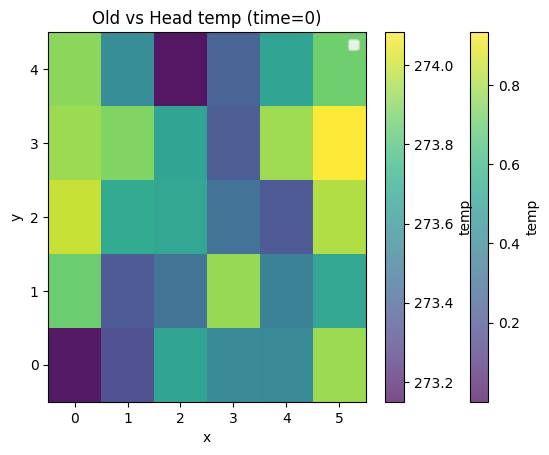

In [9]:
import matplotlib.pyplot as plt

plt.figure()
ds_old["temp"].isel(time=0).plot(label="old", alpha=0.7)
ds_head["temp"].isel(time=0).plot(label="head", alpha=0.7)
plt.legend()
plt.title("Old vs Head temp (time=0)")
plt.show()
